In [1]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt

import myokit
sys.path.append('../../../')
sys.path.append('../../../Protocols')
sys.path.append('../../../Models')
sys.path.append('../../../Lib')
import protocol_lib, vc_protocols
import mod_trace
from kylie2017IKr import Kylie2017IKr

C:\Anaconda3\envs\ml\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


Kylie dataset has been selected.
(9, 2)


In [2]:
dir_path = './Results'
try:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print('"%s" has been created.'%(dir_path))
    else:
        print("The folder already exists.")
except OSError:
    print('Error: create_folder(). : ' + dir_path)

The folder already exists.


In [3]:
exp_ds_dir = f"../herg25oc1_real_data"
sys.path.append(exp_ds_dir)
# from agetdata import get_currents_with_constant_dt
from getdata import get_dataset, get_times # cell_to_remove=[], scale=1, multi=False, torch_tensor=False

removed_cells = []
currents_exp, params_exp, cells = get_dataset( cell_to_remove=removed_cells, scale=1, multi=True, torch_tensor=False)
t_eval = get_times(scale=1)
dt = t_eval[1]-t_eval[0]
print(currents_exp.shape, params_exp.shape, t_eval.shape)

The number of full cells : 211
The number of removed Cells : 0
The number of cells : 211
(211, 77000) (211, 9) (77000,)


In [4]:
import simulator_myokit
import vc_protocols_for_myokit

start_time = time.time()
'''
Simulation setting for Myokit
'''
model_path = "../../../mmt-model-files/kylie-2017-IKr.mmt" 
m_myokit, protocol, script = myokit.load(model_path)
protocol = vc_protocols.leak_staircase()

temperature = 25.0
temperature += 273.15  # in K
m_myokit.get('phys.T').set_rhs(temperature)
m_myokit.get('potassium.Ko').set_rhs(float(4.0))
m_myokit.get('potassium.Ki').set_rhs(float(110.0))

# model, protocol, _ = vc_protocols_for_myokit.leak_staircase(model)
sim_myokit = simulator_myokit.Simulator(m_myokit, protocol, max_step=1e-5, abs_tol=1e-08, rel_tol=1e-10, vhold=-80e-3 )  # 1e-12, 1e-14  # 1e-08, 1e-10
sim_myokit.name = "kylie-2017-IKr"

print("--- %s seconds ---"%(time.time()-start_time))

--- 5.141844987869263 seconds ---


In [5]:
cellNo = 12
data_exp = {
    'cell' : cells[cellNo],
    'time' : t_eval,
    'IKr' : currents_exp[cellNo],    
    'g' : params_exp[cellNo, 0],
    'p1' : params_exp[cellNo, 1],
    'p2' : params_exp[cellNo, 2],
    'p3' : params_exp[cellNo, 3],
    'p4' : params_exp[cellNo, 4],
    'p5' : params_exp[cellNo, 5],
    'p6' : params_exp[cellNo, 6],
    'p7' : params_exp[cellNo, 7],
    'p8' : params_exp[cellNo, 8],
}
print(cells[cellNo])

A22


In [6]:
'''
Simulation
'''
start_time = time.time()

parameters = { 
    'ikr.g' :  data_exp['g'],
    'ikr.p1' : data_exp['p1'],
    'ikr.p2' : data_exp['p2'],
    'ikr.p3' : data_exp['p3'],
    'ikr.p4' : data_exp['p4'],
    'ikr.p5' : data_exp['p5'],
    'ikr.p6' : data_exp['p6'],
    'ikr.p7' : data_exp['p7'],
    'ikr.p8' : data_exp['p8'],
}

sim_myokit.set_simulation_params( parameters )
y0 = sim_myokit.pre_simulate( 100, sim_type=1)
d_myokit = sim_myokit.simulate(t_eval.max()+dt, log_times=t_eval, extra_log=['ikr.IKr', 'ikr.open', 'ikr.active'])

population_by_continent = {
    'O': d_myokit['ikr.open']*d_myokit['ikr.active'],
    'I': d_myokit['ikr.open']*(1-d_myokit['ikr.active']),
    'C': (1-d_myokit['ikr.open'])*d_myokit['ikr.active'],
    'IC': (1-d_myokit['ikr.open'])*(1-d_myokit['ikr.active']),    
}

print("--- %s seconds ---"%(time.time()-start_time))

--- 3.254937171936035 seconds ---


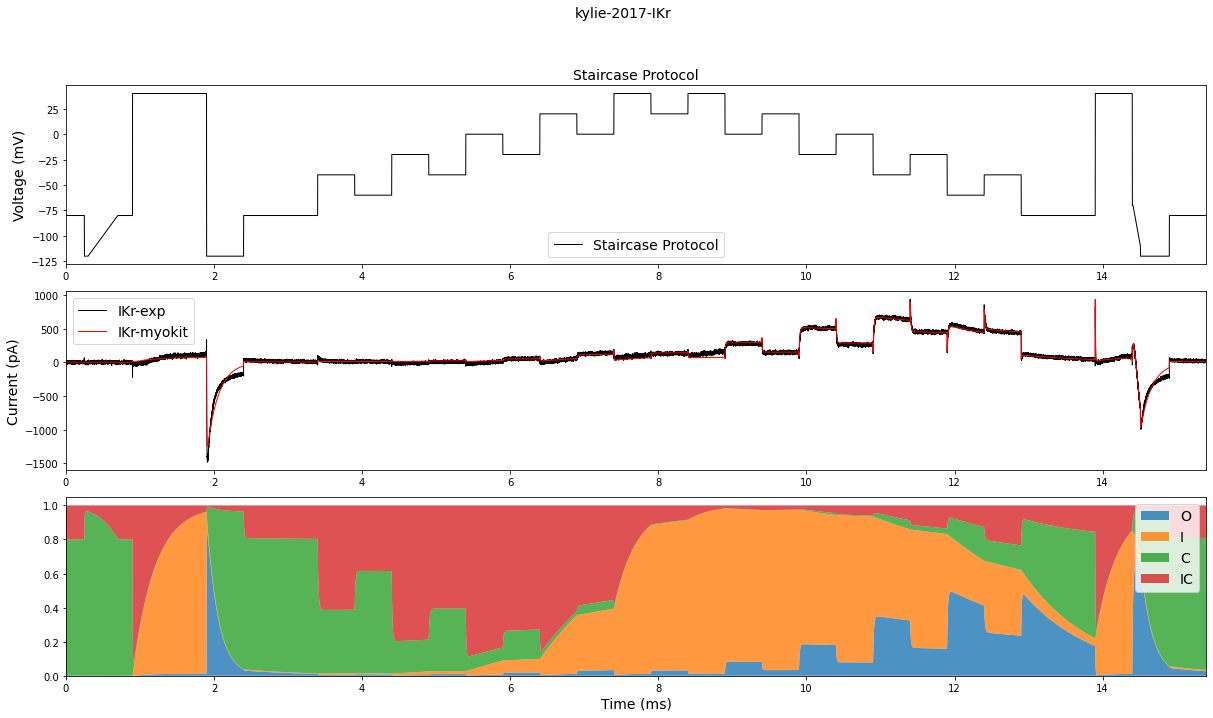

Complete


In [7]:
fig, axes = plt.subplots(3, figsize=(18, 10))
fig.suptitle(sim_myokit.name, fontsize=14)
axes[0].set_title("Staircase Protocol", fontsize=14)
axes[0].set_xlim(0, t_eval[-1])
axes[0].set_ylabel("Voltage (mV)", fontsize=14)
axes[0].plot( t_eval, d_myokit['membrane.V']*1000, label="Staircase Protocol", linewidth=1, color='k')
# textstr = "GNa : %1.4f\nGNaL : %1.4f\nGto : %1.4f\nPCa : %1.4f\nGKr : %1.4f\nGKs : %1.4f\nGK1 : %1.4f\nGf : %1.4f"%(Gs[0], Gs[1], Gs[2], Gs[3], Gs[4], Gs[5], Gs[6], Gs[7])
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# axes[0].text(0.67, 0.60, textstr, transform=axs[0].transAxes, fontsize=14, verticalalignment='top', bbox=props)    
axes[0].legend(fontsize=14)
axes[0].xaxis.set_visible(True)

axes[1].set_xlim(0, t_eval[-1])
axes[1].set_ylabel("Current (pA)", fontsize=14)
axes[1].plot(t_eval, data_exp['IKr'], label="IKr-exp", linewidth=1, color='k')
axes[1].plot(t_eval, d_myokit['ikr.IKr'], label="IKr-myokit", linewidth=1, color='r')
axes[1].legend(fontsize=14)
axes[1].xaxis.set_visible(True)

axes[2].set_xlim(0, t_eval[-1])
axes[2].set_xlabel("Time (ms)", fontsize=14)
axes[2].stackplot(t_eval, population_by_continent.values(), labels=population_by_continent.keys(), alpha=0.8)
axes[2].legend(fontsize=14)
axes[2].xaxis.set_visible(True)

plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.87, wspace=0.5, hspace=0.15)
# fig.tight_layout()#rect=[0.5, 0.5, 0.5, 0.5]
plt.show()
fig.savefig(os.path.join('Results', f"Kylie2017IKr_VC-{data_exp['cell']}-{dt}.jpg"), dpi=100)
print("Complete")

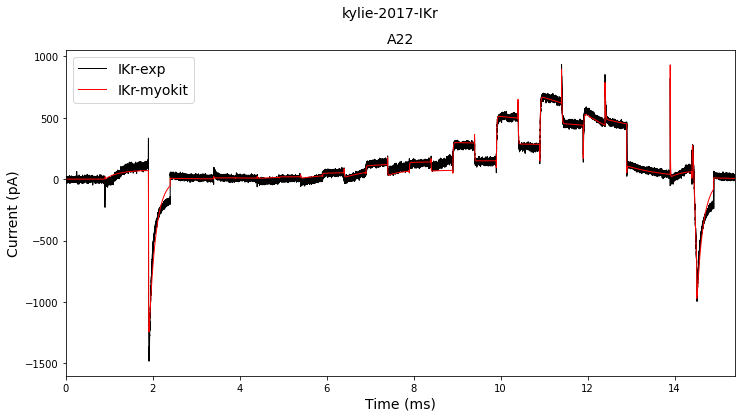

Complete


In [8]:
fig, ax = plt.subplots(1, figsize=(12, 6))
fig.suptitle(sim_myokit.name, fontsize=14)

ax.set_title(f"{cells[cellNo]}", fontsize=14)
ax.set_xlabel("Time (ms)", fontsize=14)
ax.set_xlim(0, t_eval[-1])
ax.set_ylabel("Current (pA)", fontsize=14)
ax.plot(t_eval, data_exp['IKr'], label="IKr-exp", linewidth=1, color='k')
ax.plot(t_eval, d_myokit['ikr.IKr'], label="IKr-myokit", linewidth=1, color='r')
ax.legend(fontsize=14)
ax.xaxis.set_visible(True)

# plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.87, wspace=0.5, hspace=0.15)
# fig.tight_layout()#rect=[0.5, 0.5, 0.5, 0.5]
plt.show()
fig.savefig(os.path.join('Results', f"I-{data_exp['cell']}-{dt}.jpg"), dpi=100)
print("Complete")